In [10]:
# Run some recommendation experiments using MovieLens 100K
import pandas
import numpy
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


data_dir = "data/ml-100k/"
data_shape = (943, 1682)

df = pandas.read_csv(data_dir + "ua.base", sep="\t", header=-1)

In [2]:
df.head()

,0,1,2,3
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [4]:
df.describe()

,0,1,2,3
count,90570.000000,90570.000000,90570.000000,9.057000e+04
mean,461.494038,428.104891,3.523827,8.835073e+08
std,266.004364,333.088029,1.126073,5.341684e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,256.000000,174.000000,3.000000,8.794484e+08
50%,442.000000,324.000000,4.000000,8.828143e+08
75%,682.000000,636.000000,4.000000,8.882049e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


(2, 0.96426413203468886, 1.0167867701152213)
(3, 0.95380054586590424, 1.0157582742164333)
(4, 0.94513134443821389, 1.0145592650033677)
(5, 0.93670687180079326, 1.0113762120572034)
(6, 0.92815531268621232, 1.0084504334390356)
(7, 0.92077315179172547, 1.0046728894841279)
(8, 0.91355705188978709, 1.0039932435727545)
(9, 0.90712422959286843, 1.0036202344843193)
(10, 0.90095743395724004, 1.003226297045462)
(11, 0.89506760885808845, 1.0034216514568595)
(12, 0.88925787528416211, 1.0032947217627954)
(13, 0.8833827839544629, 1.0026181410187651)
(14, 0.87785788371747264, 1.002039102399878)
(15, 0.87207781344935498, 1.0014829915218162)
(16, 0.86660582984766021, 1.0012389152368888)
(17, 0.86132995931899581, 1.0012939091758046)
(18, 0.85619035404349109, 1.001486542931705)
(19, 0.85107124790522126, 1.002188015366549)
(20, 0.84602537042090054, 1.0022307302697957)
(21, 0.84094676921253886, 1.0024252333516122)
(22, 0.83604549735449962, 1.0028006254702362)
(23, 0.83127736319252366, 1.0034730479672584)
(

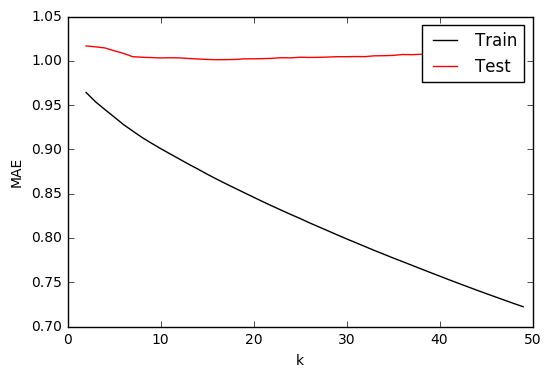

In [11]:
values = df.values
values[:, 0:2] -= 1
X_train = scipy.sparse.csr_matrix((values[:, 2], (values[:, 0], values[:, 1])), dtype=numpy.float, shape=data_shape)

df = pandas.read_csv(data_dir + "ua.test", sep="\t", header=-1)
values = df.values
values[:, 0:2] -= 1
X_test = scipy.sparse.csr_matrix((values[:, 2], (values[:, 0], values[:, 1])), dtype=numpy.float, shape=data_shape)

# Compute means of nonzero elements
X_row_mean = numpy.zeros(data_shape[0])
X_row_sum = numpy.zeros(data_shape[0])

train_rows, train_cols = X_train.nonzero()

# Iterate through nonzero elements to compute sums and counts of rows elements
for i in range(train_rows.shape[0]):
    X_row_mean[train_rows[i]] += X_train[train_rows[i], train_cols[i]]
    X_row_sum[train_rows[i]] += 1

# Note that (X_row_sum == 0) is required to prevent divide by zero
X_row_mean /= X_row_sum + (X_row_sum == 0)

# Subtract mean rating for each user
for i in range(train_rows.shape[0]):
    X_train[train_rows[i], train_cols[i]] -= X_row_mean[train_rows[i]]

test_rows, test_cols = X_test.nonzero()
for i in range(test_rows.shape[0]):
    X_test[test_rows[i], test_cols[i]] -= X_row_mean[test_rows[i]]

X_train = numpy.array(X_train.toarray())
X_test = numpy.array(X_test.toarray())

ks = numpy.arange(2, 50)
train_mae = numpy.zeros(ks.shape[0])
test_mae = numpy.zeros(ks.shape[0])
train_scores = X_train[(train_rows, train_cols)]
test_scores = X_test[(test_rows, test_cols)]

# Now take SVD of X_train
U, s, Vt = numpy.linalg.svd(X_train, full_matrices=False)

for j, k in enumerate(ks):
    X_pred = U[:, 0:k].dot(numpy.diag(s[0:k])).dot(Vt[0:k, :])

    pred_train_scores = X_pred[(train_rows, train_cols)]
    pred_test_scores = X_pred[(test_rows, test_cols)]

    train_mae[j] = mean_squared_error(train_scores, pred_train_scores)**0.5
    test_mae[j] = mean_squared_error(test_scores, pred_test_scores)**0.5

    print(k,  train_mae[j], test_mae[j])

plt.plot(ks, train_mae, 'k', label="Train")
plt.plot(ks, test_mae, 'r', label="Test")
plt.xlabel("k")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [6]:
train_scores

array([ 1.39694656, -0.60305344,  0.39694656, ..., -0.39240506,
       -0.39240506, -0.39240506])